In [1]:
from datasets import load_dataset
import json
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#path to directories (image dataset)
result_path= r'/content/drive/MyDrive/candy/labelled_images/result.json' #path to read result files
metadata_path = r'/content/drive/MyDrive/candy/labelled_images/images/metadata.jsonl'
#path for metadata file, should be in folder where you kept in labelled data images from label studio

In [58]:
#Path for the model
image_path = r'/content/drive/MyDrive/candy/labelled_images'
model_path = r'/content/drive/MyDrive/candy/candy_detector'
savepoint = r'/content/drive/MyDrive/candy/candy_detector_savepoint'
count_path = r'/content/drive/MyDrive/candy/images/cd_23.jpg'
draw_path = r'/content/drive/MyDrive/candy/images/cd_23.jpg'

In [5]:
with open(result_path) as f:
    cocodata = json.load(f)

In [6]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
    img = {'width': [], 'height':[], 'file_name':[], 'image_id':[], 'objects':[]}
    img['width'] =  image['width']
    img['height'] = image['height']
     # Remove the image directory from the file name
    img['file_name'] = image['file_name'].split('\\')[-1]
    img['image_id'] = image['id']
    # Extend the image dict with bounding boxes and class labels
    img['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
    # Iterate through the annotations (bounding boxes and labels)
    for annot in cocodata['annotations']:
        # Check if the annotation matches the image
        if annot['image_id'] == image['id']:
            # Add the annotation
            img['objects']['bbox'].append(annot['bbox'])
            img['objects']['category'].append(annot['category_id'])
            img['objects']['area'].append(annot['area'])
            img['objects']['id'].append(annot['id'])
    # Append the image dict with annotations to the list
    huggingdata.append(img)


In [7]:
with open(metadata_path, 'w+') as f:
    for item in huggingdata:
        f.write(json.dumps(item) + "\n")



In [8]:
#preprocess and train the model
candy = load_dataset('imagefolder',data_dir=image_path)
candy

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-08921625131e587c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'width', 'height', 'image_id', 'objects'],
        num_rows: 11
    })
})

In [9]:
categories = {
 'Moon': 1,
 'Insect': 2,
 'Black_star': 3,
 'Grey_star': 4,
 'Unicorn_whole': 5,
 'Unicorn_head': 6,
 'Owl': 7,
 'Cat': 8
}

id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

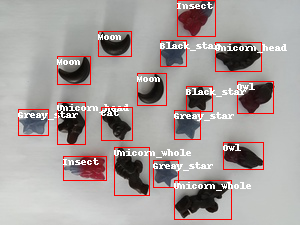

In [10]:
#Visualize the boxes

image = candy["train"][1]["image"]
annotations = candy["train"][1]["objects"]
draw = ImageDraw.Draw(image)


for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [11]:
from transformers import AutoImageProcessor, DetrModel

checkpoint = "nielsr/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [12]:
#using Albumentations to ensure transform affect the images and detect boundaries
transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=.5),
        albumentations.RandomBrightnessContrast(p=0.2),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [13]:
#adding function to reformat annotations
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [14]:
# transforming a batch by combining image and annotationstransformation
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [15]:
candy["train"]= candy["train"].with_transform(transform_aug_ann) #Training Set

In [16]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [17]:
#training the model
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at nielsr/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
training_args = TrainingArguments(
    output_dir=savepoint,
    per_device_train_batch_size=5,
    num_train_epochs=100,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [48]:
#model = AutoModelForObjectDetection.from_pretrained(model_path)
#uncomment the above step only if you are re-running the model as it will start from the savepoint
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy["train"],
    tokenizer=image_processor,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
50,0.297400
100,0.279800
150,0.274200
200,0.267600
250,0.272900
300,0.265100


TrainOutput(global_step=300, training_loss=0.27616762479146323, metrics={'train_runtime': 212.2417, 'train_samples_per_second': 5.183, 'train_steps_per_second': 1.413, 'total_flos': 7.0037152799328e+17, 'train_loss': 0.27616762479146323, 'epoch': 100.0})

In [49]:
trainer.save_model(model_path)

In [56]:
def count_candy(image):
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModelForObjectDetection.from_pretrained(model_path)

    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]

    count = [0]*len(id2label)
    for label in results["labels"]:
        count[label] = count[label] + 1

    candy_dict = {}
    for value, key in enumerate(label2id):
        candy_dict[key] = count[value]

    return candy_dict

In [61]:
def draw_candy(image):
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModelForObjectDetection.from_pretrained(model_path)

    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )

    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        x, y, x2, y2 = tuple(box)
        draw.rectangle((x, y, x2, y2), outline="red", width=1)
        draw.text((x, y), model.config.id2label[label.item()], fill="white")

    return image

Detected Greay_star with confidence 0.992 at location [118.87, 17.85, 147.72, 46.05]
Detected Insect with confidence 0.975 at location [243.47, 167.51, 286.77, 205.05]
Detected Insect with confidence 0.992 at location [75.12, 173.14, 114.87, 214.77]
Detected Unicorn_whole with confidence 0.997 at location [6.9, 60.29, 39.77, 119.91]
Detected Greay_star with confidence 0.974 at location [205.21, 36.41, 238.73, 69.34]
Detected Greay_star with confidence 0.813 at location [99.44, 102.02, 129.23, 133.3]
Detected Black_star with confidence 0.97 at location [59.47, 138.96, 89.0, 164.21]
Detected Greay_star with confidence 0.995 at location [133.18, 71.21, 162.9, 99.91]
Detected Unicorn_head with confidence 0.988 at location [59.6, 51.61, 95.27, 92.65]
Detected Greay_star with confidence 0.977 at location [30.29, 170.71, 64.81, 199.36]
Detected Owl with confidence 0.954 at location [163.33, 150.9, 194.49, 196.58]
Detected Insect with confidence 0.99 at location [168.43, 90.03, 198.3, 132.24]


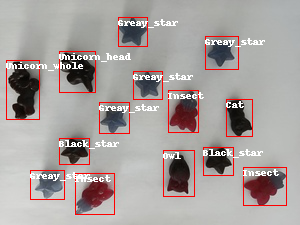

In [62]:
image_draw = Image.open(draw_path)
draw_candy(image_draw)

In [60]:
image_num = Image.open(count_path)
count_candy(image_num)

{'Black_star': 2,
 'Cat': 1,
 'Greay_star': 5,
 'Insect': 3,
 'Moon': 0,
 'Owl': 1,
 'Unicorn_head': 1,
 'Unicorn_whole': 1}